In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install contractions

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Exploration du jeu de données

In [4]:
DATASET_FILE = "drive/MyDrive/dataset.csv"

In [5]:
dataset_df = pd.read_csv(DATASET_FILE)
dataset_df.head()

,text,stars
0,I've only had food from here once and it wasn'...,1
1,I will never return here again. Ever. I was ...,1
2,I wish my experience was great as others. I di...,1
3,Are the rosemary grapefruit scones supposed to...,1
4,Our takeout order was half wrong. Food was mis...,1


## 1.1 Répartition des avis clients en fonction du nombre d'étoiles

In [6]:
stars_columns = dataset_df.stars
stars_columns

0        1
1        1
2        1
3        1
4        1
        ..
24995    5
24996    5
24997    5
24998    5
24999    5
Name: stars, Length: 25000, dtype: int64

In [7]:
stars_columns.value_counts()

5    5000
4    5000
3    5000
2    5000
1    5000
Name: stars, dtype: int64

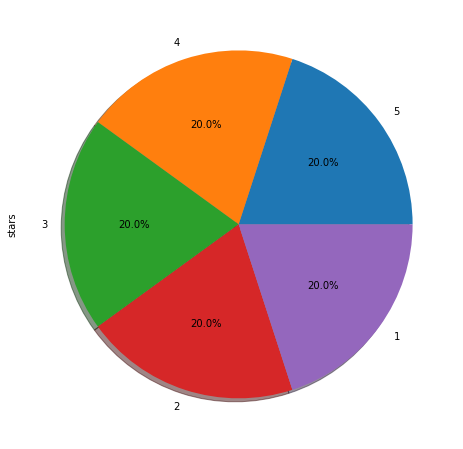

In [8]:
stars_columns.value_counts().plot(kind="pie", figsize=(10, 8), autopct="%1.1f%%", shadow=True)

## 1.2 Distribution de la longueur (nombre de mots) des avis clients

In [9]:
dataset_df["length"] = dataset_df["text"].apply(lambda x: len(x.split()))
dataset_df

,text,stars,length
0,I've only had food from here once and it wasn'...,1,68
1,I will never return here again. Ever. I was ...,1,87
2,I wish my experience was great as others. I di...,1,166
3,Are the rosemary grapefruit scones supposed to...,1,81
4,Our takeout order was half wrong. Food was mis...,1,32
...,...,...,...
24995,I was a loyal fan of Aroy before the ownership...,5,75
24996,Stopped here for a bite while wandering around...,5,55
24997,"A quiet place with excellent food, great music...",5,32
24998,Super delicious food. Awesome vibe. I suffered...,5,41


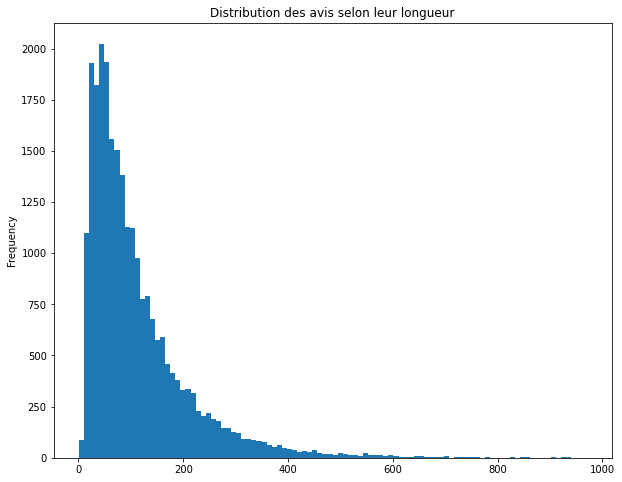

In [10]:
dataset_df.length.plot(kind="hist", bins=100, figsize=(10, 8), title='Distribution des avis selon leur longueur')

## 1.3 Distribution de la longueur des avis clients en fonction du nombre d'étoiles des avis

Text(0.5, 1.0, "Répartition des longueurs des avis en fonction du nombre d'étoiles")

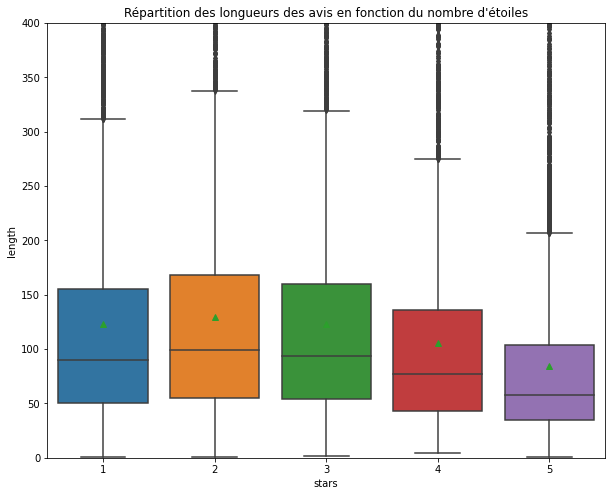

In [11]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(x=dataset_df.stars, y=dataset_df.length, showmeans=True)

ax.set_ylim(0, 400)

ax.set_title("Répartition des longueurs des avis en fonction du nombre d'étoiles")

# 2. Pré-traitement du jeu de données

In [ ]:
# Extending contracted expressions (e.g. wasn't -> was not)
dataset_df['token'] = [contractions.fix(x).lower() for x in dataset_df['text']] # .lower() transform les tokens en minuscule et .apply(tokenizer.tokenize) transforme en token


In [ ]:
# Tokenization 
dataset_df['token'] = [' '.join(tokens).split() for tokens in dataset_df['token'].apply(RegexpTokenizer(r"\w+").tokenize)] # or use RegexpTokenizer('\w+|\$[\d\.]+|\S+')
dataset_df.token[0]


In [ ]:
# Handling negative review by merging 'not' with the next word (e.g. not memorable -> not_memorable)
for token in dataset_df['token']:
  for i in range(len(token)):
    if token[i] == 'not':
      if i < len(token)-1 :
        token[i+1] =  'not_' + token[i+1]
      else:
        token[i-1] += 'not_' + token[i-1]  
                                          # Not deleting redundant 'not' strings as they're to be wiped in the stop word deletion

In [26]:
# Deleting stop words 
stop_words = set(stopwords.words('english'))
dataset_df['token'] = dataset_df['token'].apply(lambda x: [item for item in x if item not in stop_words]) 


In [ ]:
# Lemmatization with pos_tagging for a better lemmmatization 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
clean_tokens = []

for token_list in dataset_df['token']:
  token_tag = nltk.pos_tag(token_list)
  lemm_tokens = []                      # Merging lemmatized tokens review by review 
  for word, tag in token_tag :                          
    if tag.startswith('J'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'a'))
    elif tag.startswith('V'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'v'))
    elif tag.startswith('N'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'n'))
    elif tag == 'PRP' :
      lemm_tokens.append(word)
    elif tag.startswith('R'):
      lemm_tokens.append(lemmatizer.lemmatize(word,'r'))
    else :
      lemm_tokens.append(lemmatizer.lemmatize(word)) 
  clean_tokens.append(lemm_tokens)      # Adding the merged tokens into all reviews 



In [ ]:
# Formating the clean tokens into the clean text and adding it to a new dataframe 'df'
clean_text = []
for tokens in clean_tokens:
  clean_text.append(' '.join(tokens))              # Merging tokens review by review

dataset_df['clean text'] = pd.Series(clean_text)
df = dataset_df.drop(['token','test'],axis=1)      # Deleting redundant/useless pandas series

df.head()

In [66]:
# Exporting the processed dataset into a csv file
df.to_csv('drive/MyDrive/processed_dataset.csv', index= False)